In [86]:
from pathlib import Path
import subprocess
import shlex
import os
import shutil
import pandas as pd
import numpy as np
import fileinput
import matplotlib.pyplot as plt

In [88]:
def extract_failure_probability(filename='dakotaTab.out'):

    with open(filename, 'r') as file:
        data = file.readlines()
    
    # Process the data into a list of lists with high precision
    array = []
    for line in data[1:]:  # Skip the first line
        values = line.split()
        row = [float(value) for value in values[2:]]  # Convert values from index 2 onwards to Decimal
        array.append(row)
    
    # Convert the list of lists into a NumPy array with high precision
    numpy_array = np.array(array, dtype=np.float64)    
    failure_probability = np.mean(numpy_array[:, -1])
    return failure_probability, numpy_array

In [90]:
def configure_analysis(var_values_list, filename='templatedir/column_config.py'):

    var_name_list = ['DCR', 'L', 'e', 'section_size', 'fire_load_fuel_energy_density']
    
    with open(filename, 'r') as file:
        data = file.readlines()
    new_data = []
    for line in data:
        for i, var_name in enumerate(var_name_list):
            if f"<{var_name}>" in line:
                # print(f"{var_name = }")
                if var_name == 'section_size':
                    line = line.replace(f"<{var_name}>", f"'{var_values_list[i]}'")
                else:
                    line = line.replace(f"<{var_name}>", str(var_values_list[i]))
                # print(f"{line = }")
                new_data.append(line)
                break
    # data[-1] = data[-1].replace("2000", str(fire_load))
    with open(filename, 'w') as file:
        # file.writelines(data)
        file.writelines(new_data)

In [92]:
print(os.getcwd())

/Users/emilynakamura/Downloads/NHERI/Technical/REU2024/src/fragility


In [116]:
column_dataframe = pd.read_csv("ColumnDatabase.csv")
section_size_series = column_dataframe['section size']
section_size_list = section_size_series.tolist()
# print(section_size_list)
print(len(section_size_list))
group_size = 17
grouped_list = [section_size_list[i:i + group_size] for i in range(0, len(section_size_list), group_size)]
specific_group_index = 0     # 0 to 9
specific_group = grouped_list[specific_group_index]
print(specific_group)

170
['W36X652', 'W36X529', 'W36X487', 'W36X441', 'W36X395', 'W36X361', 'W27X539', 'W33X387', 'W36X330', 'W33X354', 'W36X302', 'W30X391', 'W36X282', 'W33X318', 'W30X357', 'W36X262', 'W33X291']


In [98]:
print(os.getcwd())
source = Path("tmp.SimCenter").resolve()
fire_loads = np.arange(2000, 0, -100)
# pf_list = np.zeros_like(fire_loads)
pf_list = []
# failure_indicator_values = []
fire_load_list = []
Path(source.parent / "start.txt").touch()

section_size_list = specific_group
e_list = [0.0]
L_list = [29, 25, 21, 17, 13, 12, 11, 10, 9, 8]
DCR_list = [0.95, 0.9, 0.85, 0.8, 0.75, 0.65, 0.5, 0.35, 0.25, 0.2, 0.15, 0.1, 0.05]

for section_size in section_size_list:
    for e in e_list:
        for L in L_list:
            for DCR in DCR_list:
                pf_list = []
                fire_load_list = []
                for num, fire_load in enumerate(fire_loads):
                    var_values_list = [DCR, L, e, section_size, fire_load]
                    print(num, fire_load)
                    destination = source.parent / f"analysis_{num}"
                    if destination.is_dir():
                        shutil.rmtree(destination, ignore_errors=True)
                    shutil.copytree(source, destination)
                    template_dir = destination / "templatedir"
                    os.chdir(destination)
                    configure_analysis(var_values_list)
                    command = "/Applications/quoFEM.app/Contents/MacOS/applications/dakota/bin/dakota -input dakota.in -output dakota.out -error dakota.err"
                    command_list = shlex.split(command)
                    subprocess.run(command_list)
                    pf, failure_indicator = extract_failure_probability()
                    pf_list.append(pf)
                    # failure_indicator_values.append(failure_indicator)
                    fire_load_list.append(fire_load)
                    print(pf)
                    os.chdir(destination.parent)
                    shutil.rmtree(destination, ignore_errors=True)
                    if pf == 0:
                        break 
                file_name = f"{section_size}_{int(100*e)}_{int(L)}_{int(100*DCR)}.txt"
                res_file = source.parent / file_name
#                 res_array = np.column_stack((fire_load_list, pf_list))
#                 np.savetxt(res_file, res_array, header="Fire Load, Failure Probability")

# Path(source.parent / "finish.txt").touch()
                res_array = np.concatenate(np.array(fire_load_list), np.array(pf_list), axis=0)
                with open(res_file, "w") as f:
                    np.savetxt(res_array)
Path(source.parent / "finish.txt").touch()


/Users/emilynakamura/Downloads/NHERI/Technical/REU2024/src/fragility
0 2000
0.9375
1 1900
0.9375
2 1800
0.9375
3 1700
0.9375
4 1600
0.9375
5 1500
0.9375
6 1400
0.9375
7 1300
0.9375
8 1200
0.9375
9 1100
0.875
10 1000
0.6875
11 900
0.6875
12 800
0.5
13 700
0.4375
14 600
0.4375
15 500
0.4375
16 400
0.3125
17 300
0.1875
18 200
0.1875
19 100
0.1875


TypeError: concatenate() got multiple values for argument 'axis'

In [94]:
# os.chdir(destination.parent)
os.chdir("/Users/emilynakamura/Downloads/NHERI/Technical/REU2024/src/fragility")

/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected 

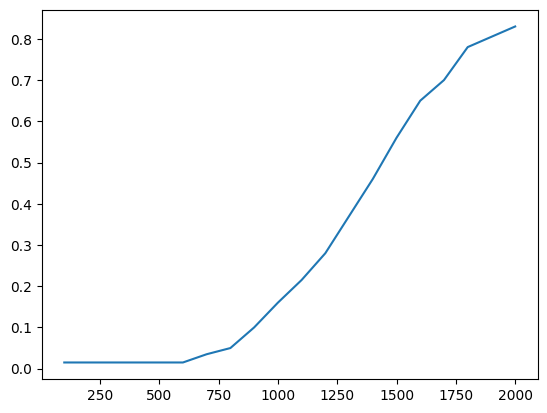

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000]
[0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.035, 0.05, 0.1, 0.16, 0.215, 0.28, 0.37, 0.46, 0.56, 0.65, 0.7, 0.78, 0.805, 0.83]


In [6]:
x = fire_load_list[::-1]
y = pf_list[::-1]
plt.plot(x, y)
plt.show()
print(x)
print(y)

Optimal parameters: [3.33544095e-01 1.82594637e-11 1.42881354e+03]
Optimal scale parameter (median): 1428.8135406484582
Optimal shape parameter (log standard deviation): 0.33354409509624094


/var/folders/tg/3gq10s7538gf87xvwtyx65xc0000gn/T/ipykernel_51757/2492380515.py:40: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("FragilityCurve.pdf")
/var/folders/tg/3gq10s7538gf87xvwtyx65xc0000gn/T/ipykernel_51757/2492380515.py:40: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("FragilityCurve.pdf")
/var/folders/tg/3gq10s7538gf87xvwtyx65xc0000gn/T/ipykernel_51757/2492380515.py:40: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("FragilityCurve.pdf")
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got un

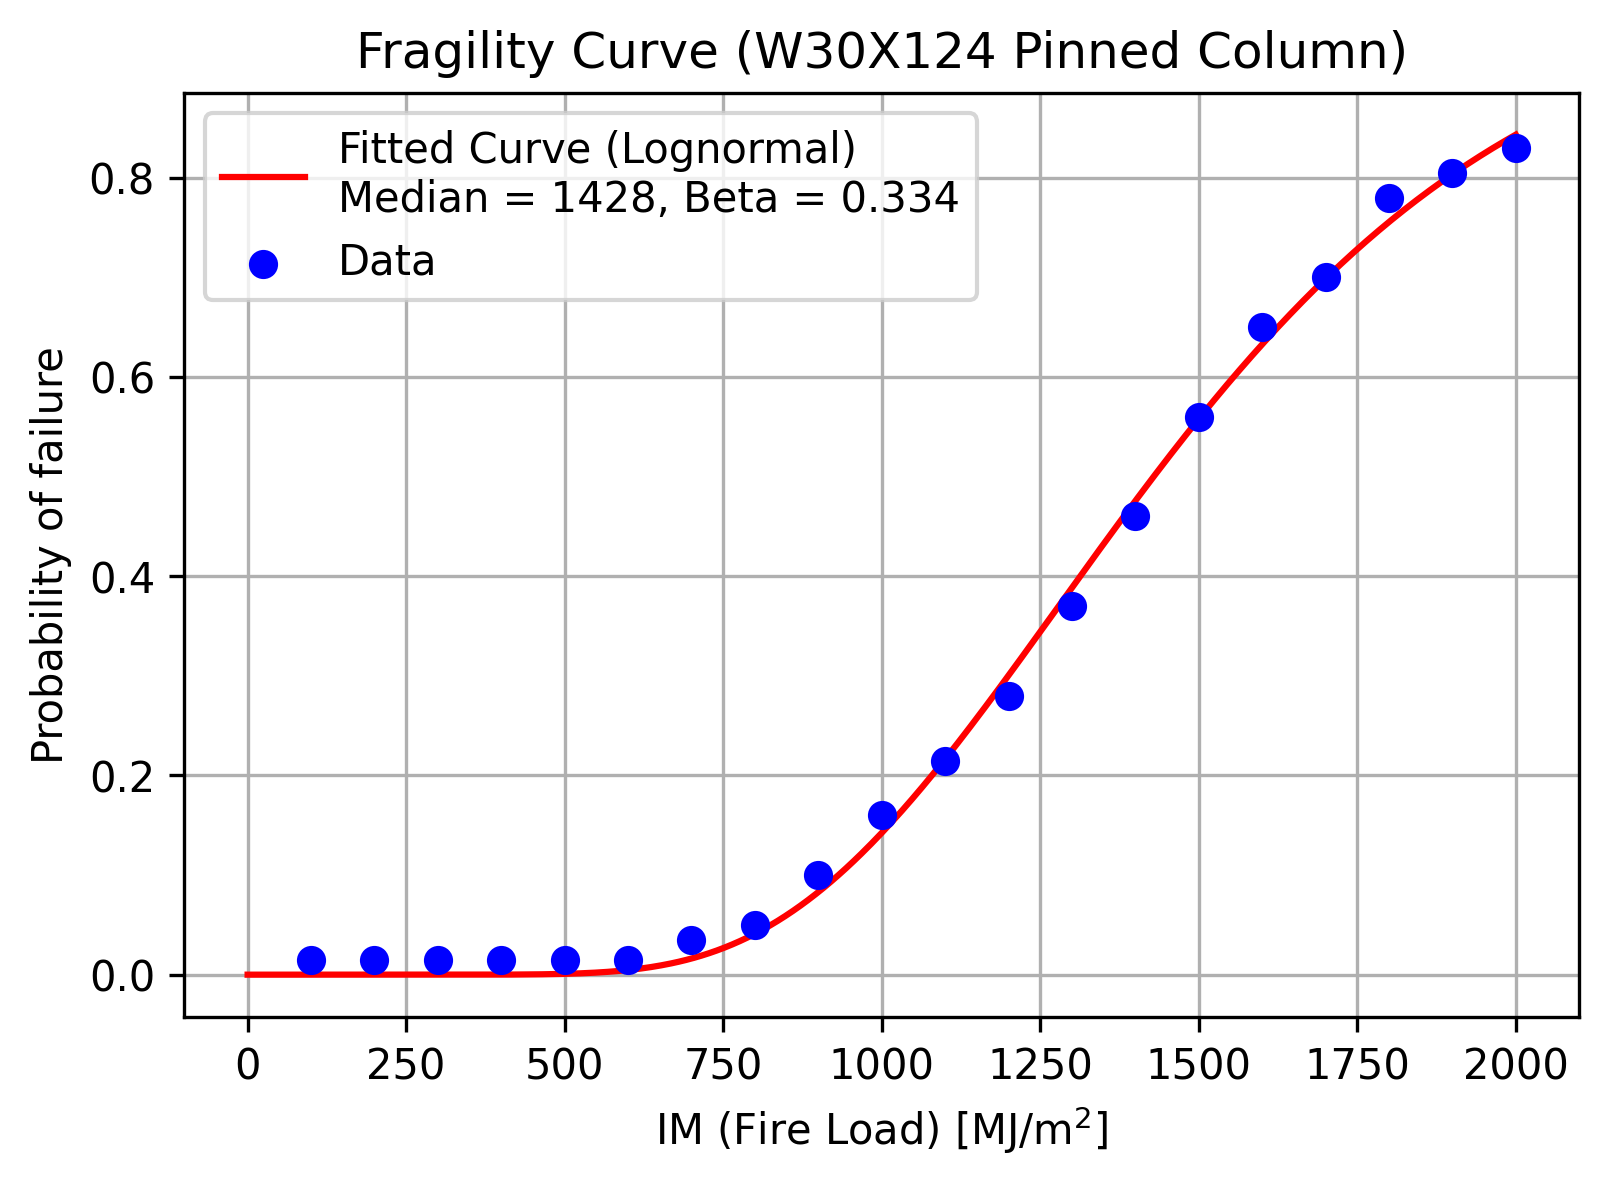

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import lognorm

def model_function(x, shape, loc, scale):
    return lognorm.cdf(x, s=shape, loc=loc, scale=scale)

# Prepare your data
IM_values = x
PF_values = y


# Set bounds for the parameters
# shape > 0, loc >= 0, scale > 0
bounds = ([0, 0, 0], [np.inf, 1e-6, np.inf])

# \Use curve_fit to fit the model to your data
popt, pcov = curve_fit(model_function, IM_values, PF_values, bounds=bounds)

# popt contains the best fit parameters a, b, and c
print("Optimal parameters:", popt)

# popt contains the best fit parameters shape, loc, and scale
shape_fit, loc_fit, scale_fit = popt

print("Optimal scale parameter (median):", scale_fit)
print("Optimal shape parameter (log standard deviation):", shape_fit)

# Plot the data and the fitted curve
x1 = np.linspace(0, 2000, 501)
plt.figure(figsize=(6, 4), dpi=300)
plt.scatter(IM_values, PF_values, label='Data', color='blue', zorder=20)
plt.plot(x1, model_function(x1, *popt), label=f'Fitted Curve (Lognormal)\nMedian = {int(scale_fit):d}, Beta = {shape_fit:.3g}', color='red', zorder=10)
plt.xlabel("IM (Fire Load) [MJ/m$^2$]")
plt.ylabel("Probability of failure")
plt.legend()
plt.title('Fragility Curve (W30X124 Pinned Column)')
plt.grid()
plt.savefig("FragilityCurve.pdf")
plt.show()


Optimal parameters: [3.33544095e-01 1.82581495e-11 1.42881354e+03]
Optimal scale parameter (median): 1428.813540587291
Optimal shape parameter (log standard deviation): 0.3335440949991697


/var/folders/tg/3gq10s7538gf87xvwtyx65xc0000gn/T/ipykernel_51757/3239768062.py:43: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("FragilityCurveIllustration.pdf")
/var/folders/tg/3gq10s7538gf87xvwtyx65xc0000gn/T/ipykernel_51757/3239768062.py:43: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("FragilityCurveIllustration.pdf")
/var/folders/tg/3gq10s7538gf87xvwtyx65xc0000gn/T/ipykernel_51757/3239768062.py:43: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("FragilityCurveIllustration.pdf")
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: Matplotlib

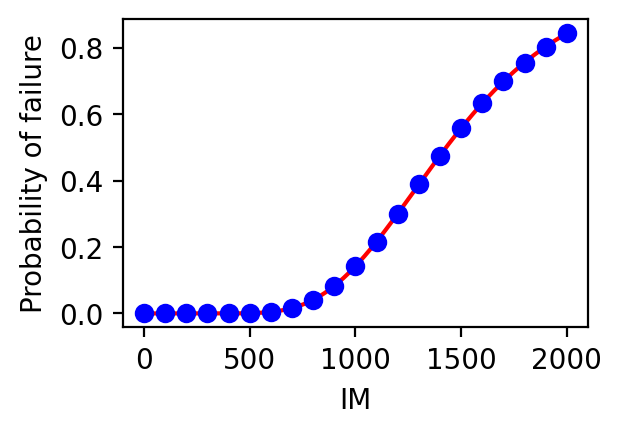

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import lognorm

def model_function(x, shape, loc, scale):
    return lognorm.cdf(x, s=shape, loc=loc, scale=scale)

# Prepare your data
IM_values = x
PF_values = y


# Set bounds for the parameters
# shape > 0, loc >= 0, scale > 0
bounds = ([0, 0, 0], [np.inf, 1e-6, np.inf])

# \Use curve_fit to fit the model to your data
popt, pcov = curve_fit(model_function, IM_values, PF_values, bounds=bounds)

# popt contains the best fit parameters a, b, and c
print("Optimal parameters:", popt)

# popt contains the best fit parameters shape, loc, and scale
shape_fit, loc_fit, scale_fit = popt

print("Optimal scale parameter (median):", scale_fit)
print("Optimal shape parameter (log standard deviation):", shape_fit)

x2 = np.linspace(0, 2000, 21)
y2 = model_function(x2, *popt)

# Plot the data and the fitted curve
x1 = np.linspace(0, 2000, 501)
plt.figure(figsize=(3, 2), dpi=200)
plt.scatter(x2, y2, label='Data', color='blue', zorder=20)
plt.plot(x1, model_function(x1, *popt), label=f'Fitted Curve (Lognormal)\nMedian = {int(scale_fit):d}, Beta = {shape_fit:.3g}', color='red', zorder=10)
plt.xlabel("IM")
plt.ylabel("Probability of failure")
# plt.legend()
# plt.title('Fragility Curve (W14X68 Pinned Column)')
# plt.grid()
plt.savefig("FragilityCurveIllustration.pdf")
plt.show()



In [9]:
# pf_list = [0.24, 0.14, 0.1, 0.08, 0.04, 0.04, 0.04, 0.0]

In [10]:
# plt.plot(fire_loads[:8], pf_list)
# plt.show()

In [11]:
# os.chdir(destination)
# command = "/Applications/quoFEM.app/Contents/MacOS/applications/dakota/bin/dakota -input dakota.in -output dakota.out -error dakota.err"
# command_list = shlex.split(command)
# subprocess.run(command_list)
# pf = extract_failure_probability()
# pf_list[num] = pf
# print(pf)
# os.chdir(destination.parent)
# shutil.rmtree(destination, ignore_errors=True)


In [12]:
print(os.getcwd())
print(destination)
print(destination.parent)

/Users/emilynakamura/Downloads/NHERI/Technical/REU2024/src/fragility
/Users/emilynakamura/Downloads/NHERI/Technical/REU2024/src/fragility/analysis_19
/Users/emilynakamura/Downloads/NHERI/Technical/REU2024/src/fragility


In [13]:
# os.chdir(destination.parent)

In [14]:
# # emily numpy, but sig fig prom
# file = "dakotaTab.out"
# with open(file, 'r') as file:
#     data = file.readlines()

# array = []
# for line in data[1:]:  # Skip the first line
#     values = line.split()
#     row = [float(value) for value in values[2:]]  # Convert values from index 2 onwards to float
#     array.append(row)

# numpy_array = np.array(array)
# print(numpy_array)

# row_index = 1  # Replace with the row index you want to access
# col_index = 3  # Replace with the column index you want to access

# # Access the value
# specific_value = numpy_array[row_index, col_index]
# print(f"The value at row {row_index + 1} and column {col_index + 1} is {specific_value}")

In [15]:
# # emily pandas, but sig fig problem
# import pandas as pd

# # Define the filename
# filename = "dakotaTab.out"  # Replace with your actual file name

# # Read the file into a DataFrame
# df = pd.read_csv(filename, delim_whitespace=True, converters={'interface': str})

# # Display the DataFrame
# pd.set_option('display.precision', 15)
# print("DataFrame:")
# print(df)

# numpy_array = df.iloc[:, 2:].to_numpy()  # Skip the first two columns

# # Display the NumPy array
# print("\nNumPy array:")
# print(numpy_array)


In [16]:
# df = pd.read_csv("dakotaTab.out", delimiter="\t").to_numpy()
# df = df[:, 2:]

In [17]:
# data = np.genfromtxt("dakotaTab.out", delimiter='\t', skip_header=1)

In [18]:
# display(df)


In [19]:
# df